In [1]:
import numpy as np
import pandas as pd
from itertools import combinations

from IPython.display import display
from plotnine import *

from wvu.util import plot_roc
from vtreat.partial_pooling_estimator import pooled_effect_estimate, standard_effect_estimate


In [2]:
rng = np.random.default_rng(2024)

In [3]:
d = pd.DataFrame({
    'rate': rng.choice(
        [1/4, 1/2, 3/4],
        size=400,
        replace=True,
        p=[1/3, 1/3, 1/3],
    )
})

In [4]:
d['location_id'] = [
    f'loc_{r}_{i}' for i, r in zip(
        rng.choice(100, size=10000, replace=True),
        d['rate']
    )]
d['observation'] = rng.binomial(n=1, p=d['rate'], size=d.shape[0])
d['rate_group'] = [f'{r}' for r in d['rate']]

In [5]:
d

,rate,location_id,observation,rate_group
0,0.75,loc_0.75_79,1,0.75
1,0.25,loc_0.25_19,0,0.25
2,0.25,loc_0.25_43,0,0.25
3,0.75,loc_0.75_86,1,0.75
4,0.75,loc_0.75_98,0,0.75
...,...,...,...,...
395,0.25,loc_0.25_49,0,0.25
396,0.25,loc_0.25_61,0,0.25
397,0.25,loc_0.25_32,0,0.25
398,0.25,loc_0.25_76,0,0.25


In [6]:
(
    d
        .loc[:, ['rate_group', 'observation']]
        .groupby(['rate_group'])
        .mean()
)

,observation
rate_group,
0.25,0.243421
0.5,0.477273
0.75,0.810345


In [7]:
r = standard_effect_estimate(d)


In [8]:
r.loc[
    (r['impact'] >= np.max(r['impact']))
    | (r['impact'] <= np.min(r['impact'])),
    :]

,location_id,mean,var,size,estimate,grand_mean,impact
0,loc_0.25_0,0.0,0.0,4,0.0,0.485,-0.485
1,loc_0.25_1,1.0,NaN,1,1.0,0.485,0.515
2,loc_0.25_12,0.0,0.0,2,0.0,0.485,-0.485
3,loc_0.25_13,1.0,NaN,1,1.0,0.485,0.515
4,loc_0.25_14,0.0,NaN,1,0.0,0.485,-0.485
...,...,...,...,...,...,...,...
211,loc_0.75_93,1.0,NaN,1,1.0,0.485,0.515
212,loc_0.75_95,1.0,NaN,1,1.0,0.485,0.515
213,loc_0.75_96,1.0,0.0,2,1.0,0.485,0.515
215,loc_0.75_98,0.0,NaN,1,0.0,0.485,-0.485


In [9]:
standard_estimate = {k: v for k, v in zip(r['location_id'], r['impact'])}
d['standard estimate'] = [standard_estimate[l] for l in d['location_id']]

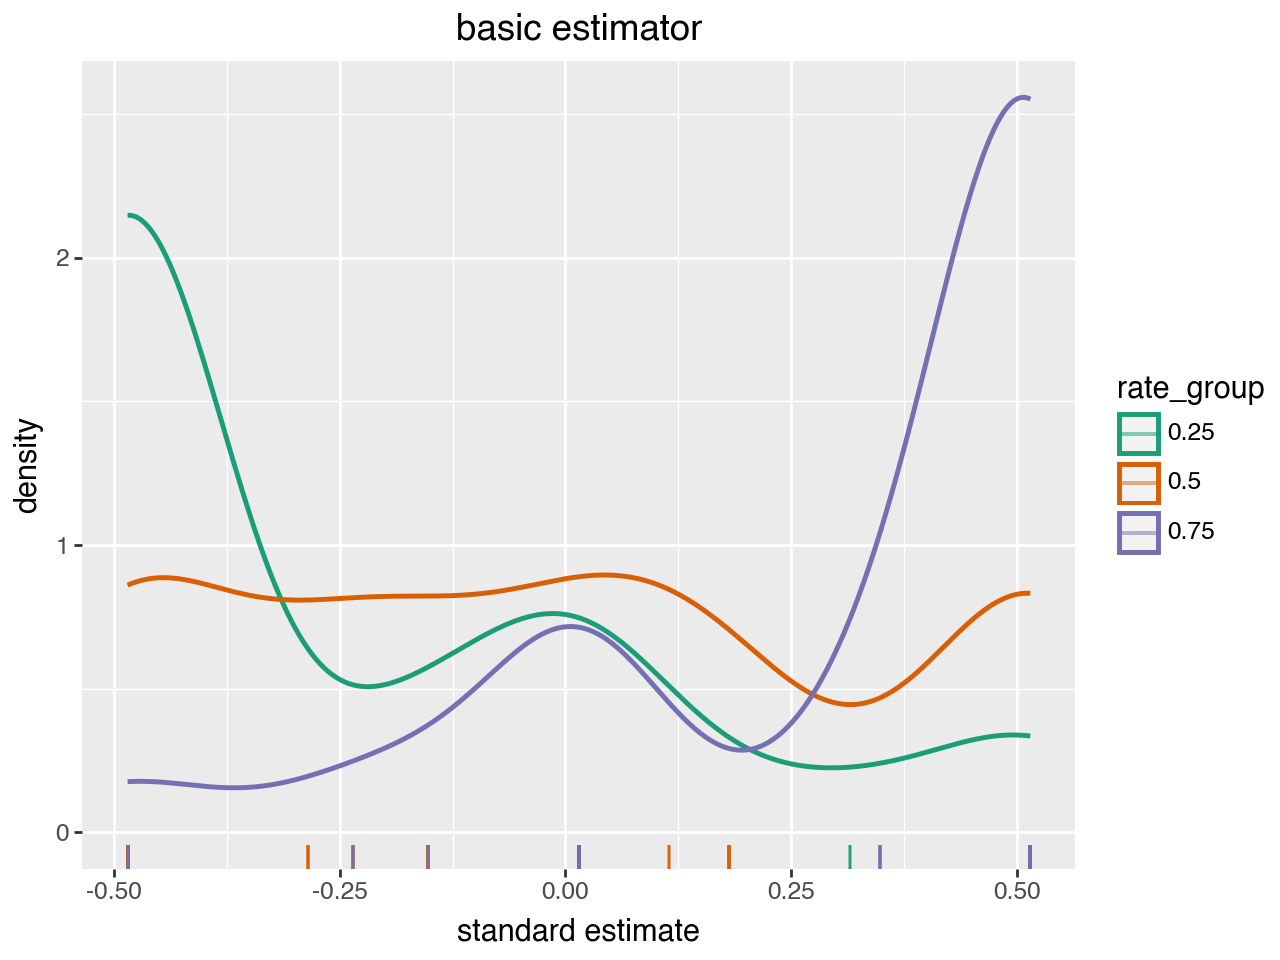

In [10]:
(
    ggplot(
        data=d,
        mapping=aes(x='standard estimate', color='rate_group'),
    )
    + geom_density(size=1)
    + geom_rug(alpha=0.5)
    + scale_color_brewer(type='qual', palette = 'Dark2')
    + ggtitle("basic estimator")
)

In [11]:
r2 = pooled_effect_estimate(d)
r2['rate_group'] = [lid.split('_')[1] for lid in r2['location_id']]

In [12]:
r2.loc[
    (r2['impact'] >= np.max(r2['impact']))
    | (r2['impact'] <= np.min(r2['impact'])),
    :]

,location_id,mean,var,size,estimate,grand_mean,impact,rate_group
58,loc_0.25_76,0.0,0.0,5,0.020068,0.485,-0.462945,0.25
190,loc_0.75_64,1.0,0.0,4,0.968683,0.485,0.485670,0.75


In [13]:
pooled_estimate = {k: v for k, v in zip(r2['location_id'], r2['impact'])}
d['pooled estimate'] = [pooled_estimate[l] for l in d['location_id']]

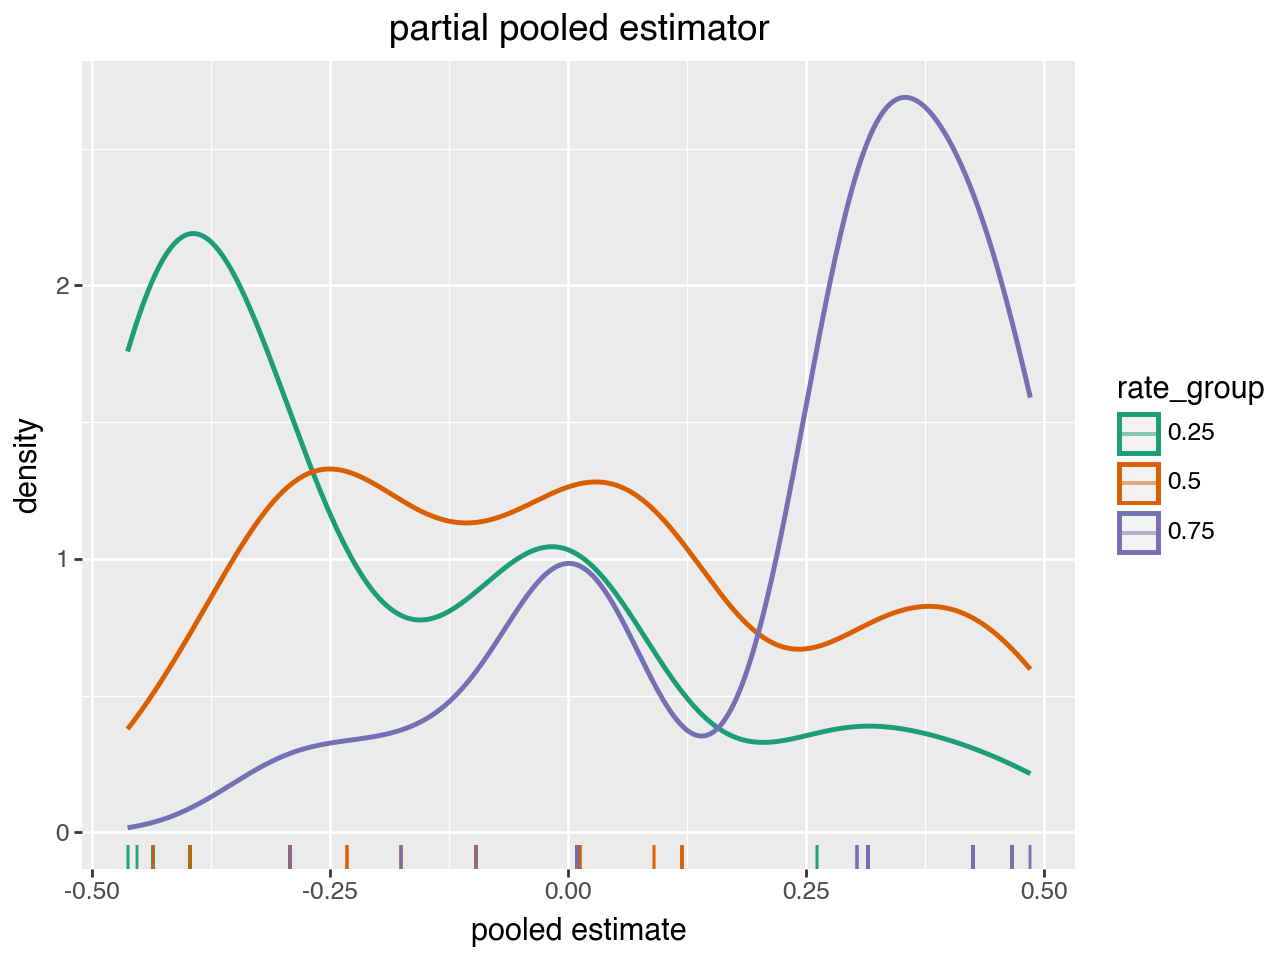

In [14]:
(
    ggplot(
        data=d,
        mapping=aes(
            x='pooled estimate', 
            color='rate_group'),
    )
    + geom_density(size=1)
    + geom_rug(alpha=0.5)
    + scale_color_brewer(type='qual', palette = 'Dark2')
    + ggtitle("partial pooled estimator")
)

In [15]:
rate_groups = sorted(set(d['rate_group']))

<Figure size 640x480 with 0 Axes>

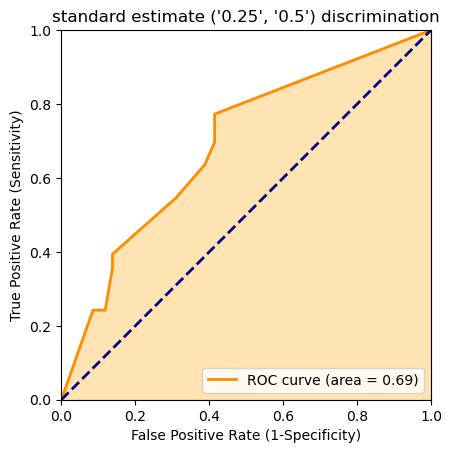

0.6877741228070176

<Figure size 640x480 with 0 Axes>

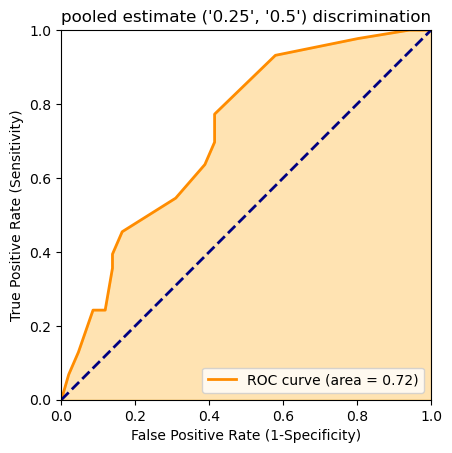

0.7216905901116428

<Figure size 640x480 with 0 Axes>

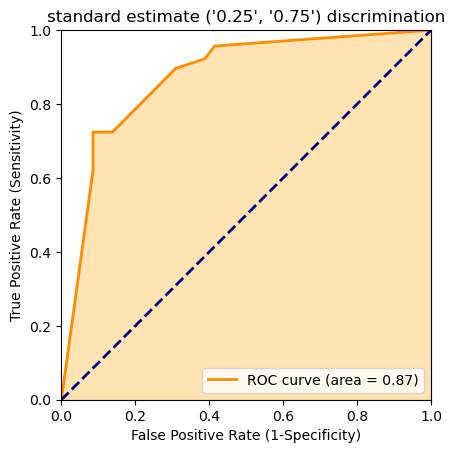

0.8727030399274047

<Figure size 640x480 with 0 Axes>

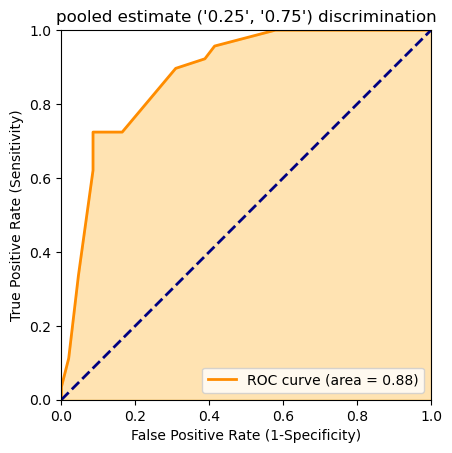

0.8791969147005445

<Figure size 640x480 with 0 Axes>

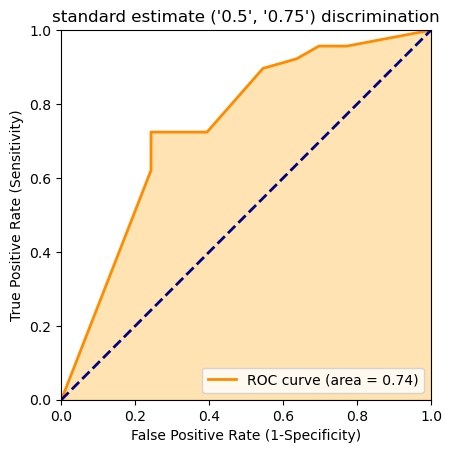

0.7422283176593522

<Figure size 640x480 with 0 Axes>

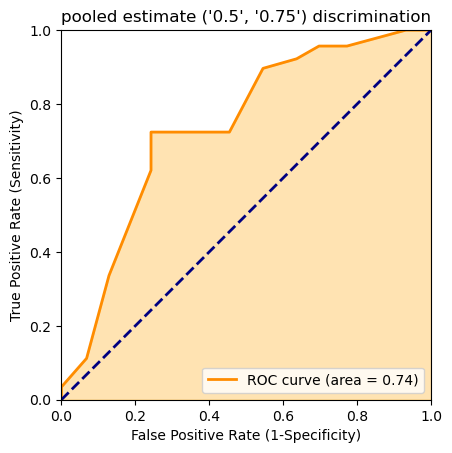

0.736187304075235

In [16]:
for pair in combinations(rate_groups, 2):
    d_sub = d.loc[np.isin(d['rate_group'], pair), :].reset_index(drop=True, inplace=False)
    _ = display(plot_roc(
        prediction=d_sub['standard estimate'],
        istrue=d_sub['rate_group'] == pair[1],
        title=f'standard estimate {pair} discrimination',
    ))
    _ = display(plot_roc(
        prediction=d_sub['pooled estimate'],
        istrue=d_sub['rate_group'] == pair[1],
        title=f'pooled estimate {pair} discrimination',
    ))